In [1]:
# demo de-noising using fhmm
# this was attempt 1, all is working but need to streamline so that
# it's simpler to run lots of tests

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/tests/selecting_amount_of_states_hmm', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [29]:
from whale.setup import get_data, constants, annotations
import importlib
importlib.reload(constants)

importlib.reload(get_data)
from final import useful
importlib.reload(useful)

HUMPBACK_A = 'humpback_a'
HUMPBACK_B = 'humpback_b'
HUMPBACK_C = 'humpback_c'
BOWHEAD = 'bowhead'
NOISE = 'noise'

# constants for fe and what not
fs = 4000

signal_types = [HUMPBACK_A, HUMPBACK_B, BOWHEAD, NOISE] # HUMPBACK_C

# type to label
signal_types_labels = {
    HUMPBACK_A: 0,
    HUMPBACK_B: 1,
    # HUMPBACK_C: 2,
    BOWHEAD: 2,
    NOISE: 3
}

# label to type
label_to_type = {
    0: HUMPBACK_A,
    1: HUMPBACK_B,
    # 2: HUMPBACK_C,
    2: BOWHEAD,
    3: NOISE
}

get_data_dict = {
    HUMPBACK_A: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.SWOOPS_LABELS_A, fs, useful.file_to_audio)],
    HUMPBACK_B:[get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HIGH_CALLS_LABELS_A, fs, useful.file_to_audio)],
    # HUMPBACK_C:[get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_MOOS, fs, useful.file_to_audio)],
    BOWHEAD: [get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_WHALE, fs, useful.file_to_audio)],
    NOISE: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_A_NOISE, fs, useful.file_to_audio),
            get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_NOISE, fs, useful.file_to_audio)]
}

samples, labels = useful.get_samples(get_data_dict, signal_types, signal_types_labels)

__collected samples__
humpback_a :  18
humpback_b :  11
bowhead :  34
noise :  62


In [30]:
noise_sample_indicies = np.where(np.array(labels) == 3)[0]
noise_sample_indicies_2nd = [index for index in range(1, len(noise_sample_indicies), 2)]
noise_sample_indicies = noise_sample_indicies[noise_sample_indicies_2nd]

In [31]:
noise_sample_indicies = np.sort(noise_sample_indicies)[::-1]
samples = [value for i, value in enumerate(samples) if i not in noise_sample_indicies]
labels = [value for i, value in enumerate(labels) if i not in noise_sample_indicies]

In [32]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3]), array([18, 11, 34, 31]))

In [33]:
import noisey

def get_feature(samp, nfft):
    # add optionals here if needed
    # mfcc
    # feat = librosa.feature.mfcc(y=samp,sr=4000,n_mfcc=13).T
    feat = useful.get_log_power_feature(samp, nfft=nfft)
    return feat

signal_avg_db = -16 # from inspection

def get_noise_for_sample(sig_db, sample, snr_1=30, snr_2=30, snr_3=30):
    noise_power_1 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_1)
    noise_power_2 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_2)
    noise_power_3 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_3)
    noise_sample, _ = noisey.generate_gaussian_noise(len(sample), noise_power_1, noise_power_2, noise_power_3)
    return noise_sample

In [40]:
# separate using cross-validation
import final.cross_validation as cv
from final.cross_validation import *
import importlib
importlib.reload(cv)

n_folds = 4
cv_output = cv.split_data_for_cross_validation(samples, labels, n_folds, test_ratio=0.2)

In [41]:
from hmmlearn.hmm import GaussianHMM

trains = []
vals = []
tests = []
noise_hmms = []
nfft = 128

for i in range(n_folds):
    cv_index = i
    train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
    val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
    test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_LABEL])

    train.features = []
    for i in range(len(train.samples)):
        feature = get_feature(train.samples[i], nfft=nfft)[:,2:]
        train.features.append(feature)

    val.features = []
    noise_samples = []
    noise_features = []

    for i in range(len(val.samples)):
         # ---- noise / reverb adjustments ---- START
        noise_sample = get_noise_for_sample(signal_avg_db, val.samples[i], 15, 15, 12)
        noise_samples.append(noise_sample)
        noise_features.append(get_feature(noise_sample, nfft=nfft)[:,2:])
        adjusted_sample = val.samples[i] + noise_sample
        # ---- noise / reverb adjustments ---- END

        feature = get_feature(adjusted_sample, nfft=nfft)[:,2:]
        val.features.append(feature)
    val.update_feature_labels()

    noise_hmm = GaussianHMM(5, covariance_type='diag', init_params='')
    noise_hmm.fit(np.concatenate(noise_features))

    trains.append(train)
    vals.append(val)
    tests.append(test)
    noise_hmms.append(noise_hmm)

    # test.features = []
    # for i in range(len(test.samples)):
    #
    #     # ---- noise / reverb adjustments ---- START
    #     noise_sample = get_noise_for_sample(signal_avg_db, test.samples[i], 30, 30, 30)
    #     noise_samples.append(noise_sample)
    #     noise_features.append(get_feature(noise_sample, nfft=nfft))
    #     adjusted_sample = test.samples[i] + noise_sample
    #     # ---- noise / reverb adjustments ---- END
    #
    #     feature = get_feature(adjusted_sample, nfft=nfft)
    #     test.features.append(feature)
    # test.update_feature_labels()

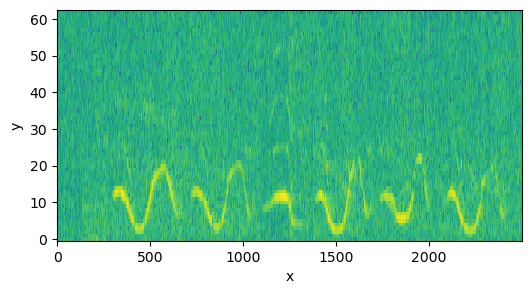

In [42]:
import final.useful
useful.vis_helper(np.concatenate(vals[0].features)[:2500])

In [287]:
# cv_index = 1    # select train and test for this iteration
importlib.reload(useful)
# train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
# val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
# test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_LABEL])


In [16]:
def calculate_average(list_of_dicts):
    result_dict = {}
    dict_count = len(list_of_dicts)

    if dict_count == 0:
        return result_dict  # Return an empty dictionary if the input list is empty

    # Iterate through each dictionary in the list
    for data_dict in list_of_dicts:
        # Iterate through each key-value pair in the dictionary
        for key, value in data_dict.items():
            # Check if the key is already present in the result_dict
            if key in result_dict:
                # If present, add the value to the running sum
                result_dict[key] += value
            else:
                # If not present, initialize the key in the result_dict
                result_dict[key] = value

    # Calculate the average for each key
    for key in result_dict.keys():
        result_dict[key] /= dict_count

    return result_dict

In [43]:
from final.tests import decode_combine as dc
importlib.reload(dc)
from final.models.fhmm import FactorialHMM
import pandas as pd

n_components = [2,4,6,8,10,12,14,16] # [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
dict_results = {}
dict_average = {}
cv_index = 0
its = 4

for n_components_index in range(len(n_components)):
    print('n components', n_components[n_components_index])
    component_results = []
    for cv_index in range(n_folds):
        print('cv_index', cv_index)

        for it in range(its):
            print('its', it)

            train = trains[cv_index]
            val = vals[cv_index]

            hmms = {
                HUMPBACK_A: GaussianHMM(n_components[n_components_index], covariance_type='diag'),
                HUMPBACK_B: GaussianHMM(n_components[n_components_index], covariance_type='diag'),
                BOWHEAD: GaussianHMM(n_components[n_components_index], covariance_type='diag'),
                NOISE: GaussianHMM(n_components[n_components_index], covariance_type='diag')
            }

            for key in hmms:
                cur_hmm = hmms[key]
                feat_indicis = train.sample_labels == signal_types_labels[key]
                hmm_features = [item for item, condition in zip(train.features, feat_indicis) if condition]
                cur_hmm.fit(np.concatenate(hmm_features))

            fhmms = {}
            for key in hmms:
                fhmm = FactorialHMM(hmms[key], noise_hmms[cv_index])
                fhmms[key] = fhmm.hmm

            combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

            _, val_pred_fhmm, val_log_prob_fhmm = combined_model_fhmm.decode_hmmlearn(np.concatenate(val.features))

            metrics = useful.perf_measure(np.concatenate(val.feature_labels), val_pred_fhmm)
            print(metrics)
            dict_results[str(cv_index) + '-' + str(it) + '-' + str(n_components[n_components_index])] = metrics
            component_results.append(metrics)

    cur_avg = calculate_average(component_results)
    df = pd.DataFrame([cur_avg])
    print(n_components[n_components_index], ' : ', df)
    # dicts_results[str(nfft_index) + str(cv_index)] = df
    dict_average[str(n_components[n_components_index])] = df

    # combined_model = dc.DecodeCombineGaussian([hmm for hmm in hmms.values()])
    #
    # _, val_pred, _ = combined_model.decode_hmmlearn(np.concatenate(val.features))
    # metrics = useful.perf_measure(np.concatenate(val.feature_labels), val_pred)
    # print(metrics)
    #
    # dict_results[n_components[n_components_index]] = metrics

n components 2
cv_index 0
its 0
{'ACC': 0.4525862068965517, 'TPR': 0.41379310344827586, 'FPR': 0.49310344827586206, 'TNR': 0.506896551724138, 'PPV': 0.5401929260450161, 'NPV': 0.38181818181818183, 'FNR': 0.5862068965517241, 'FDR': 0.45980707395498394}
its 1
{'ACC': 0.5406301824212272, 'TPR': 0.473972602739726, 'FPR': 0.35714285714285715, 'TNR': 0.6428571428571429, 'PPV': 0.6705426356589147, 'NPV': 0.4434782608695652, 'FNR': 0.5260273972602739, 'FDR': 0.32945736434108525}
its 2
{'ACC': 0.4960380348652932, 'TPR': 0.3916083916083916, 'FPR': 0.28217821782178215, 'TNR': 0.7178217821782178, 'PPV': 0.7466666666666667, 'NPV': 0.35714285714285715, 'FNR': 0.6083916083916084, 'FDR': 0.25333333333333335}
its 3
{'ACC': 0.44585091420534456, 'TPR': 0.4077669902912621, 'FPR': 0.5016722408026756, 'TNR': 0.4983277591973244, 'PPV': 0.5283018867924528, 'NPV': 0.3791348600508906, 'FNR': 0.5922330097087378, 'FDR': 0.4716981132075472}
cv_index 1
its 0
{'ACC': 0.8342370255615802, 'TPR': 0.8672936259143156, 'F

Some rows of transmat_ have zero sum because no transition from the state was ever observed.


{'ACC': 0.8079800498753117, 'TPR': 0.827683615819209, 'FPR': 0.23062730627306274, 'TNR': 0.7693726937269373, 'PPV': 0.8754980079681275, 'NPV': 0.695, 'FNR': 0.17231638418079095, 'FDR': 0.12450199203187251}
its 3
{'ACC': 0.8176060797973401, 'TPR': 0.8505747126436781, 'FPR': 0.2467289719626168, 'TNR': 0.7532710280373832, 'PPV': 0.8705882352941177, 'NPV': 0.7209302325581395, 'FNR': 0.14942528735632185, 'FDR': 0.12941176470588237}
cv_index 2
its 0
{'ACC': 0.734008866371121, 'TPR': 0.7034220532319392, 'FPR': 0.25987841945288753, 'TNR': 0.7401215805471124, 'PPV': 0.3510436432637571, 'NPV': 0.9258555133079848, 'FNR': 0.2965779467680608, 'FDR': 0.6489563567362429}
its 1
{'ACC': 0.8879082082965578, 'TPR': 0.6411290322580645, 'FPR': 0.04293785310734463, 'TNR': 0.9570621468926553, 'PPV': 0.8071065989847716, 'NPV': 0.9049145299145299, 'FNR': 0.3588709677419355, 'FDR': 0.19289340101522842}
its 2
{'ACC': 0.7284325637910085, 'TPR': 0.7147887323943662, 'FPR': 0.2687224669603524, 'TNR': 0.7312775330396

In [44]:
concatenated_df = pd.concat(dict_average.values(), axis=0, ignore_index=True)